In [ ]:
import pandas as pd
import numpy as np
import pytz
import datetime as dt
import matplotlib.pyplot as plt
from fredapi import Fred  # https://github.com/mortada/fredapi
import yfinance as yf
import pandas as pd

# Define the ETF tickers
tickers = ["TQQQ", "TMF", "TMV"]

# Define the start and end dates
start_date = "2015-01-01"
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y-%m-%d")

In [10]:
# Fetch data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker", auto_adjust=True)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


In [14]:
# Flatten the multi-level columns
instrument_df = data.stack(level=0).reset_index()
instrument_df.columns = ["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]

C:\Users\yanzh\AppData\Local\Temp\ipykernel_39852\3726135505.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  instrument_df = data.stack(level=0).reset_index()


In [ ]:
# Set your FRED API key
fred = Fred(api_key="a2f764c752a965bbb9829e967f8d759d")

# Get the different rates
rates = {
    "3Month": fred.get_series("DGS3MO"),
    "1Year": fred.get_series("DGS1"),
    "2Year": fred.get_series("DGS2"),
    "5Year": fred.get_series("DGS5"),
    "10Year": fred.get_series("DGS10"),
    "20Year": fred.get_series("DGS20"),
    "30Year": fred.get_series("DGS30"),
}

# Combine them into a single DataFrame
rates_df = pd.DataFrame(rates)

In [16]:
# Convert start_date and end_date to datetime
start_datetime = pd.to_datetime(str(start_date), format="%Y-%m-%d")
end_datetime = pd.to_datetime(end_date, format="%Y-%m-%d")

# Slice the dataframe from start_date to end_date
rates_df = rates_df.loc[start_datetime:end_datetime]

# Drop rows with NaN values
rates_df.dropna(inplace=True)

# Name the index to TRADE_DT
rates_df.index.name = "Date"

In [25]:
merged_df = pd.merge(left=instrument_df, right=rates_df, on="Date")
merged_df.set_index("Date", inplace=True)

In [ ]:
# Function to calculate rebalancing dates based on a custom window
def calculate_rebalance_dates(start_date, end_date, rebalance_window, all_dates):
    rebalance_dates = []
    current_date = start_date
    while current_date <= end_date:
        rebalance_dates.append(current_date)
        next_index = all_dates.get_loc(current_date) + rebalance_window
        if next_index < len(all_dates):
            current_date = all_dates[next_index]
        else:
            break
    return rebalance_dates

TQQQ TMF

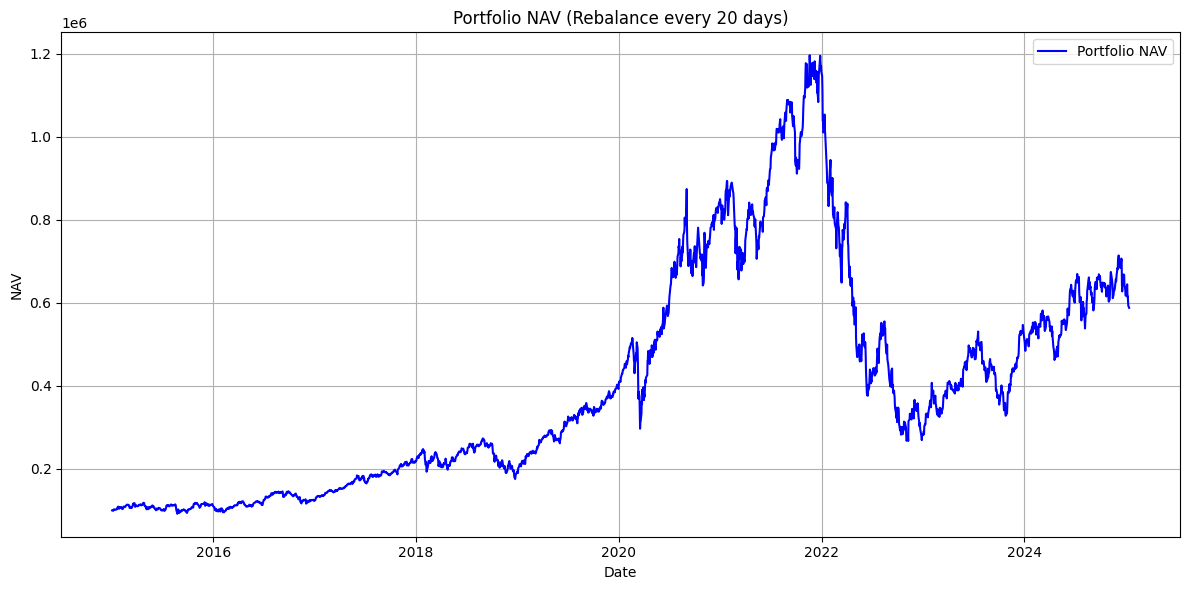

In [ ]:
df = merged_df.copy()

# Sort the DataFrame by index for proper processing
df = df.sort_index()

# Step 1: Set the Parameters
rebalance_window = 20  # Days between rebalances
initial_value = 100000
weights = {"TQQQ": 0.6, "TMF": 0.4}
shares = {"TQQQ": 0, "TMF": 0}

# Step 2: Split into TQQQ and TMF data
tqqq_data = df[df["Ticker"] == "TQQQ"]
tmf_data = df[df["Ticker"] == "TMF"]

# Step 3: Create daily portfolio value DataFrame
portfolio_daily = pd.DataFrame(index=tqqq_data.index)
portfolio_daily["TQQQ_Close"] = tqqq_data["Close"]
portfolio_daily["TMF_Close"] = tmf_data["Close"]

# Step 4: Define rebalancing parameters
all_dates = portfolio_daily.index.get_level_values("Date").unique()
start_date = all_dates.min()
end_date = all_dates.max()
rebalance_dates = calculate_rebalance_dates(start_date, end_date, rebalance_window, all_dates)

# Calculate portfolio values
portfolio_daily["Realized_PnL"] = 0.0
portfolio_daily["Unrealized_PnL"] = 0.0
last_rebalance_total = initial_value

for i, date in enumerate(portfolio_daily.index):
    if date in rebalance_dates:
        # Rebalance portfolio
        if i == 0:
            # Initial portfolio setup
            shares["TQQQ"] = (initial_value * weights["TQQQ"]) / portfolio_daily.loc[date, "TQQQ_Close"]
            shares["TMF"] = (initial_value * weights["TMF"]) / portfolio_daily.loc[date, "TMF_Close"]

        else:
            # Calculate current total value before rebalancing
            current_tqqq_value = shares["TQQQ"] * portfolio_daily.loc[date, "TQQQ_Close"]
            current_tmf_value = shares["TMF"] * portfolio_daily.loc[date, "TMF_Close"]
            current_total = current_tqqq_value + current_tmf_value

            # Update shares based on new weights
            shares["TQQQ"] = (current_total * weights["TQQQ"]) / portfolio_daily.loc[date, "TQQQ_Close"]
            shares["TMF"] = (current_total * weights["TMF"]) / portfolio_daily.loc[date, "TMF_Close"]

    # Update daily portfolio values
    portfolio_daily.loc[date, "TQQQ_value"] = shares["TQQQ"] * portfolio_daily.loc[date, "TQQQ_Close"]
    portfolio_daily.loc[date, "TMF_value"] = shares["TMF"] * portfolio_daily.loc[date, "TMF_Close"]
    portfolio_daily.loc[date, "Total_value"] = portfolio_daily.loc[date, "TQQQ_value"] + portfolio_daily.loc[date, "TMF_value"]


# Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(
    portfolio_daily.index,
    portfolio_daily["Total_value"],
    label="Portfolio NAV",
    color="blue",
)
plt.title(f"Portfolio NAV (Rebalance every {rebalance_window} days)")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

TQQQ TMF TMV 同时 rebalance

In [ ]:
df = merged_df.copy()

# Parameters
rebalance_window = 20  # Days between rebalances
initial_value = 100000
weights = {"TQQQ": 0.6, "TMF_TMV": 0.4}

# Step 1: Calculate Adjusted Close Prices
df["Adj_Close"] = df["Close"]

# Add yield spread to DataFrame
df["Yield_Spread"] = df["10Year"] - df["2Year"]

# Normalize spread to calculate TMF and TMV weights
max_spread = df["Yield_Spread"].max()
min_spread = df["Yield_Spread"].min()


# Function to calculate rate change
def calculate_rate_change(df, lookback_period=20):
    """
    Calculate recent rate changes (momentum) to adjust TMF and TMV weights.
    Args:
        df (pd.DataFrame): DataFrame with yield data.
        lookback_period (int): Number of days to look back for rate changes.
    Returns:
        pd.Series: Rate change momentum (e.g., for 2-Year and 10-Year yields).
    """
    df["Rate_Change_2Y"] = df["2Year"].diff(lookback_period)
    df["Rate_Change_10Y"] = df["10Year"].diff(lookback_period)
    return df


# Update DataFrame with rate change
lookback_period = 10  # Customize the lookback period
df = calculate_rate_change(df, lookback_period)


# Function to calculate TMF and TMV weights dynamically
def calculate_tmf_tmv_weights(row):
    """
    Dynamically calculate TMF and TMV weights based on rate momentum.
    Args:
        row (pd.Series): Row containing rate change data.
    Returns:
        tuple: Weights for TMF and TMV.
    """
    rate_change = row["Rate_Change_2Y"]  # Use 2-Year rate change as the signal
    if rate_change > 0:  # Rising rates (favor TMV)
        tmf_ratio = max(0, 0.5 - rate_change / 0.5)  # Scale TMF down as rates rise
    else:  # Falling rates (favor TMF)
        tmf_ratio = min(1, 0.5 - rate_change / 0.5)  # Scale TMF up as rates fall
    tmv_ratio = 1 - tmf_ratio
    return tmf_ratio, tmv_ratio


# Add TMF and TMV weights to the DataFrame
df[["TMF_Weight", "TMV_Weight"]] = df.apply(lambda row: pd.Series(calculate_tmf_tmv_weights(row)), axis=1)

# Initialize portfolio
all_dates = portfolio_daily.index.get_level_values("Date").unique()
portfolio_daily["TQQQ_Close"] = df[df["Ticker"] == "TQQQ"]["Adj_Close"]
portfolio_daily["TMF_Close"] = df[df["Ticker"] == "TMF"]["Adj_Close"]
portfolio_daily["TMV_Adj_Close"] = df[df["Ticker"] == "TMV"]["Adj_Close"]

# Rebalance portfolio dynamically
shares = {"TQQQ": 0, "TMF": 0, "TMV": 0}
all_dates = portfolio_daily.index.get_level_values("Date").unique()
start_date = all_dates.min()
end_date = all_dates.max()
rebalance_dates = calculate_rebalance_dates(start_date, end_date, rebalance_window, all_dates)

for i, date in enumerate(portfolio_daily.index):
    if date in rebalance_dates:
        # Rebalance
        total_value = initial_value if date == portfolio_daily.index[0] else portfolio_daily.loc[date, "Total_value"]

        # Get TMF and TMV weights for the specific date
        tmf_weight = df[df["Ticker"] == "TMF"]["TMF_Weight"]
        tmv_weight = df[df["Ticker"] == "TMV"]["TMV_Weight"]

        # Allocate dynamically
        tmf_allocation = total_value * weights["TMF_TMV"] * tmf_weight
        tmv_allocation = total_value * weights["TMF_TMV"] * tmv_weight
        tqqq_allocation = total_value * weights["TQQQ"]

        # Compute shares
        shares["TQQQ"] = tqqq_allocation / portfolio_daily.loc[date, "TQQQ_Close"]
        shares["TMF"] = tmf_allocation.iloc[0] / portfolio_daily.loc[date, "TMF_Close"]
        shares["TMV"] = tmv_allocation.iloc[0] / portfolio_daily.loc[date, "TMV_Adj_Close"]

    # Update daily portfolio values
    portfolio_daily.loc[date, "TQQQ_shares"] = shares["TQQQ"]
    portfolio_daily.loc[date, "TMF_shares"] = shares["TMF"]
    portfolio_daily.loc[date, "TMV_shares"] = shares["TMV"]
    portfolio_daily.loc[date, "TQQQ_value"] = shares["TQQQ"] * portfolio_daily.loc[date, "TQQQ_Close"]
    portfolio_daily.loc[date, "TMF_value"] = shares["TMF"] * portfolio_daily.loc[date, "TMF_Close"]
    portfolio_daily.loc[date, "TMV_value"] = shares["TMV"] * portfolio_daily.loc[date, "TMV_Adj_Close"]
    portfolio_daily.loc[date, "Total_value"] = (
        portfolio_daily.loc[date, "TQQQ_value"] + portfolio_daily.loc[date, "TMF_value"] + portfolio_daily.loc[date, "TMV_value"]
    )

# Calculate daily PnL
portfolio_daily["Daily_PnL"] = portfolio_daily["Total_value"].diff()
portfolio_daily["Cumulative_PnL"] = portfolio_daily["Daily_PnL"].cumsum()

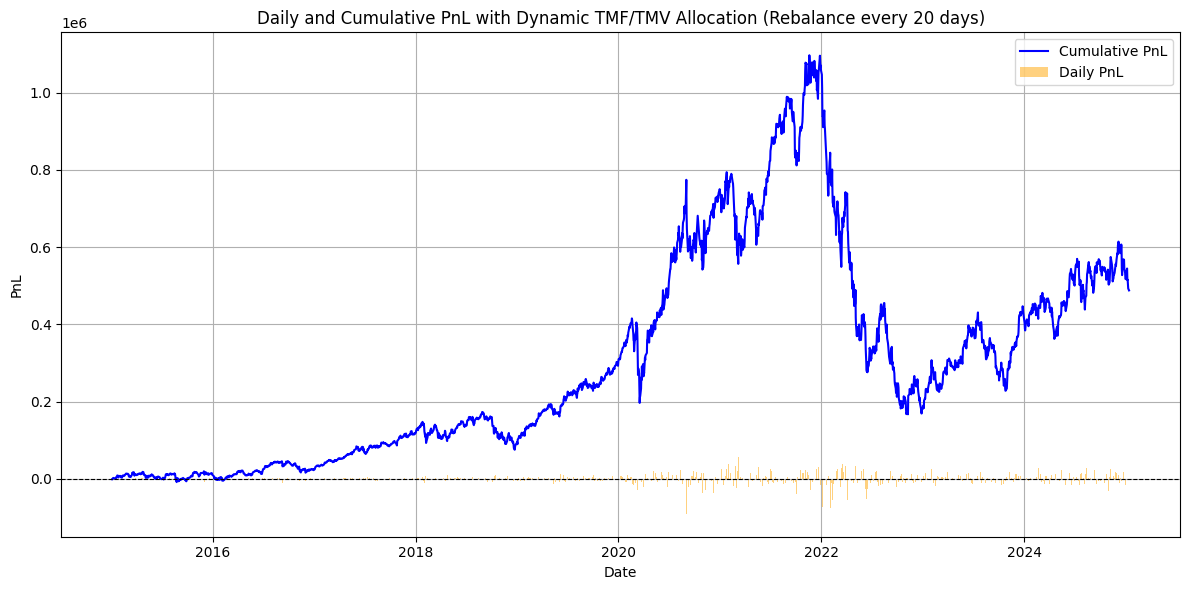

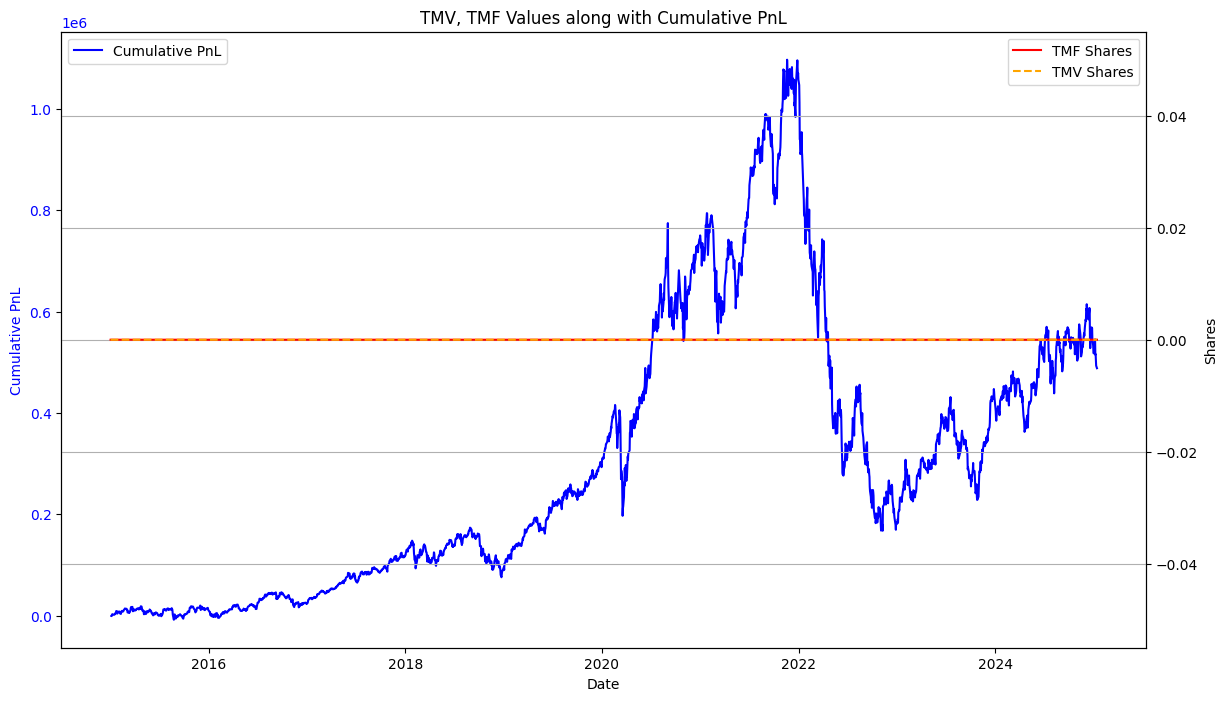

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(portfolio_daily.index, portfolio_daily["Cumulative_PnL"], label="Cumulative PnL", color="blue")
plt.bar(portfolio_daily.index, portfolio_daily["Daily_PnL"], label="Daily PnL", color="orange", alpha=0.5)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title(f"Daily and Cumulative PnL with Dynamic TMF/TMV Allocation (Rebalance every {rebalance_window} days)")
plt.xlabel("Date")
plt.ylabel("PnL")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()
# Plot the TMV, TMF shares along with the cumulative PnL

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot cumulative PnL
ax1.plot(portfolio_daily.index, portfolio_daily["Cumulative_PnL"], label="Cumulative PnL", color="blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="upper left")

# Create a second y-axis to plot the value
ax2 = ax1.twinx()
ax2.plot(portfolio_daily.index, portfolio_daily["TMV_value"], label="TMF Shares", color="red", linestyle="-")
ax2.plot(portfolio_daily.index, portfolio_daily["TMV_value"], label="TMV Shares", color="orange", linestyle="--")
ax2.set_ylabel("Shares", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.legend(loc="upper right")

plt.title("TMV, TMF Values along with Cumulative PnL")
plt.grid()
plt.show()